# Nearest neighbor with KDTree


In [54]:
from scipy.spatial import KDTree, distance
import numpy as np
from pprint import pp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [55]:
# Example
points_ref = np.array([(1, 1), (3, 3), (4, 4), (5, 4), (6, 6)])
refTree = KDTree(points_ref)
idx = refTree.query_ball_point((4, 4), 2)
pp(idx)
pp(points_ref[idx])

[1, 2, 3]
array([[3, 3],
       [4, 4],
       [5, 4]])


In [56]:
# Constructing centroids of zones
ncol = 2
nZones = 6
nrows = nZones

# Make sure I have unique index
idxStart = random.randint(100, 200)
cols = [f"W{i+1}" for i in range(ncol)]
idx = [f"c{i+idxStart}" for i in range(nrows)]
X = pd.DataFrame(np.random.random(size=(nrows, ncol)), columns=cols, index=idx)
y = [i for i in range(nrows)]
y = pd.Series(y, index=idx, name="Cy")
zc = pd.concat([y, X], axis=1)
zc = zc.sample(frac=1)
display(zc)

,Cy,W1,W2
c145,0,0.693887,0.186628
c149,4,0.279232,0.972036
c150,5,0.896757,0.524845
c147,2,0.232092,0.079213
c148,3,0.771043,0.176034
c146,1,0.411527,0.717278


In [57]:
# Constructing unsupervised fingerprints
nrows = 200
idxStart = random.randint(100, 200)
idx = [f"u{i+idxStart}" for i in range(nrows)]
uFp = pd.DataFrame(np.random.random(size=(nrows, ncol)), columns=cols, index=idx)
display(uFp)

,W1,W2
u131,0.088468,0.761199
u132,0.544271,0.979327
u133,0.725966,0.373047
u134,0.465102,0.968962
u135,0.968084,0.646128
...,...,...
u326,0.146451,0.232300
u327,0.462008,0.891491
u328,0.747722,0.347330
u329,0.326149,0.805741


<Axes: xlabel='W1', ylabel='W2'>

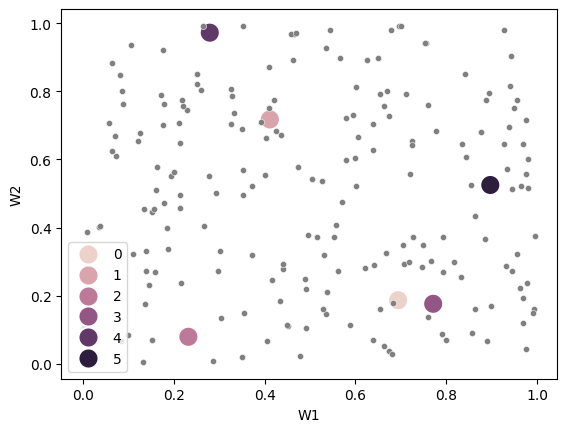

In [58]:
fig, ax = plt.subplots()
sns.scatterplot(zc, x="W1", y="W2", hue="Cy", ax=ax, s=200)
sns.scatterplot(uFp, x="W1", y="W2", ax=ax, color="gray", s=20)

In [59]:
# Find nearest neighbors
refPts = zc[cols]
refLabels = zc["Cy"]
queryPts = zc[cols]
removeSelf = True
k = 6

# ---------------------------------
refTree = KDTree(refPts)
distArr, idxArr = refTree.query(queryPts, k=k)
pp(idxArr)
pp(distArr)


def rowFn(row, refPts, refLabels):
    k = int(row.shape[0] / 2)
    srIdx = row.iloc[:k].reset_index(drop=True).astype(int)
    nnCy = srIdx.apply(
        lambda idx: refLabels.iloc[idx] if idx < refLabels.shape[0] else None
    )
    nnCyIdx = srIdx.apply(
        lambda idx: refPts.index.values[idx] if idx < refPts.shape[0] else None
    )

    nnCyDist = row.iloc[k:].reset_index(drop=True)
    nnCyDist.replace([np.inf, -np.inf], None, inplace=True)
    dft = pd.DataFrame({"nnCy": nnCy, "nnCyDist": nnCyDist, "nnCyIdx": nnCyIdx})
    dft = dft[dft["nnCyDist"] != 0] # Drop self point
    dft = dft.dropna() # Drop invalid entries
    
    
    res = pd.Series(
        [
            dft["nnCy"].values.tolist(),
            dft["nnCyDist"].values.tolist(),
            dft["nnCyIdx"].values.tolist(),
            dft.shape[0],
        ],
        index=["nnCy", "nnCyDist", "nnCyIdx", "nnCyK"],
    )
    return res


dft = pd.DataFrame(np.concatenate([idxArr, distArr], axis=1), index=refPts.index)
zcSelfNn = dft.apply(lambda row: rowFn(row, refPts, refLabels), axis=1)
display(zcSelfNn)

array([[0, 4, 2, 3, 5, 1],
       [1, 5, 2, 0, 3, 4],
       [2, 4, 0, 5, 1, 3],
       [3, 0, 4, 5, 2, 1],
       [4, 0, 2, 3, 5, 1],
       [5, 1, 2, 0, 4, 3]], dtype=int64)
array([[0.        , 0.07787926, 0.39439466, 0.47412272, 0.60109662,
        0.88814712],
       [0.        , 0.28706027, 0.76244158, 0.88814712, 0.89406668,
        0.93568009],
       [0.        , 0.37077402, 0.39439466, 0.52199505, 0.76244158,
        0.80022938],
       [0.        , 0.47412272, 0.54757789, 0.66281504, 0.80022938,
        0.89406668],
       [0.        , 0.07787926, 0.37077402, 0.54757789, 0.64976674,
        0.93568009],
       [0.        , 0.28706027, 0.52199505, 0.60109662, 0.64976674,
        0.66281504]])


,nnCy,nnCyDist,nnCyIdx,nnCyK
c145,"[3, 5, 2, 1, 4]","[0.07787925817680122, 0.394394657986848, 0.474...","[c148, c150, c147, c146, c149]",5
c149,"[1, 5, 0, 2, 3]","[0.2870602740095728, 0.7624415772983749, 0.888...","[c146, c150, c145, c147, c148]",5
c150,"[3, 0, 1, 4, 2]","[0.37077402288067707, 0.394394657986848, 0.521...","[c148, c145, c146, c149, c147]",5
c147,"[0, 3, 1, 5, 4]","[0.47412271997968364, 0.5475778891683257, 0.66...","[c145, c148, c146, c150, c149]",5
c148,"[0, 5, 2, 1, 4]","[0.07787925817680122, 0.37077402288067707, 0.5...","[c145, c150, c147, c146, c149]",5
c146,"[4, 5, 0, 3, 2]","[0.2870602740095728, 0.5219950500797166, 0.601...","[c149, c150, c145, c148, c147]",5


In [60]:
refPts = uFp[cols]
queryPts = zc[cols]
queryRadius = zcSelfNn["nnCyDist"].apply(lambda d: d[0])
queryRadius = queryRadius * 0.5  # Half distance to nearnest neighbor


def getNN(row, refTree, refPts):
    radius = row["radius"]
    srIdx = [idx for idx in row.index if idx not in ["radius"]]
    pt = row[srIdx]
    nnIdx = refTree.query_ball_point(pt, radius)

    refPtsSelected = refPts.iloc[nnIdx, :]
    _dists = distance.cdist([pt], refPtsSelected)
    dists = pd.Series(_dists[0], index=refPtsSelected.index, name="nnAugDist")
    dft = pd.concat([refPtsSelected, dists], axis=1)
    dft = dft.sort_values(by="nnAugDist")
    dft = dft[dft["nnAugDist"]!=0]
    res = pd.Series(
        [dft.index.values.tolist(), dft["nnAugDist"].values.tolist(), dft.shape[0]],
        index=["nnAugIdx", "nnAugDist", "nnAugK"],
    )
    return res


refTree = KDTree(refPts)
queryRadius.name = "radius"
dft = pd.concat([queryPts, queryRadius], axis=1)
zcAug = dft.apply(lambda row: getNN(row, refTree, refPts), axis=1)
display(zcAug)

,nnAugIdx,nnAugDist,nnAugK
c145,[u144],[0.013771691206998836],1
c149,"[u256, u312, u235, u288]","[0.025171659911330763, 0.0755635465888226, 0.1...",4
c150,"[u238, u180, u213, u292, u272, u240, u260, u22...","[0.04292700153185022, 0.049824708562982684, 0....",17
c147,"[u167, u190, u297, u136, u204, u174, u218, u26...","[0.0808365767183336, 0.08829589992588634, 0.09...",21
c148,[],[],0
c146,"[u225, u168, u299, u259, u170, u184, u242, u14...","[0.02008998863849951, 0.03509762365300433, 0.0...",11


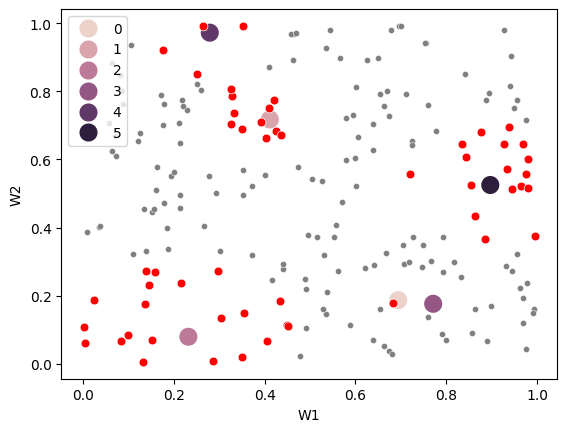

In [61]:
fig, ax = plt.subplots()
sns.scatterplot(zc, x="W1", y="W2", hue="Cy", ax=ax, s=200)
sns.scatterplot(uFp, x="W1", y="W2", ax=ax, color="gray", s=20)

for idx in zc.index:
    idxAug = zcAug.loc[idx, "nnAugIdx"]
    augPts = uFp.loc[idxAug, :]
    sns.scatterplot(augPts, x="W1", y="W2", ax=ax, color="red", s=40)